In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from math import pi, floor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import requests
from torch.autograd import Variable
from forward import FourierDomain
import core
from fft import roll, fftshift, ifftshift
from torch.fft import ifftn, fftn
from IQA_pytorch import SSIM

def psnr(img1, img2):
    mse = torch.mean((img1 * 255 - img2 * 255) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

torch.autograd.set_detect_anomaly(True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

name = 'test.jpeg'
filepath = 'filepath/' + name
adv_filepath = 'adv_filepath/' + name

In [2]:
# Choose the pytorch model for which you want to generate adversarial attack

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
resnet50.to(device)

# vgg16 = models.vgg16(pretrained=True)
# vgg16.eval()
# vgg16.to(device)

# mobilenet = models.mobilenet_v3_large(pretrained=True)
# mobilenet.eval()
# mobilenet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
## Set random seed for reproducibility

manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
## mean and std will remain same irresptive of the model you use
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess11 = transforms.Compose([
    transforms.Normalize(mean, std)
])

labels_link = "https://savan77.github.io/blog/labels.json" # download readable labels
labels_json = requests.get(labels_link).json()
labels = {int(idx): label for idx, label in labels_json.items()}

In [5]:
## find inputIntensityFT

img = Image.open(filepath)
tf = transforms.ToTensor()
IMG = tf(img)
IMG2 = core.imresize(IMG, sizes=(448, 448))
IMG2 = IMG2.unsqueeze(0)

# fourier transform은 각 채널별로 진행되어야함.
inputIntensityFT_R = fftshift(fftn(IMG2[:,0,:,:])).squeeze(0)
inputIntensityFT_G = fftshift(fftn(IMG2[:,1,:,:])).squeeze(0)
inputIntensityFT_B = fftshift(fftn(IMG2[:,2,:,:])).squeeze(0)
inputIntensityFT = torch.stack([inputIntensityFT_R, inputIntensityFT_G, inputIntensityFT_B])
inputIntensityFT = (inputIntensityFT * 255).permute(1, 2, 0)
inputIntensityFT = inputIntensityFT.detach().to(device)

gorilla, Gorilla gorilla
98.92350006103516


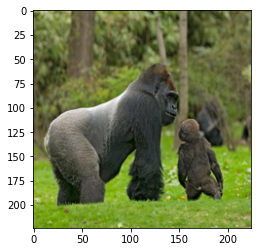

In [6]:
## original image (ground truth)

image_tensor = core.imresize(IMG, sizes=(224, 224))
image_tensor = image_tensor.detach().to(device)

## simulation experiment의 경우 여기서 attack=False 형태로 이미징 시스템 통과시킴
## real experiment의 경우 이미 이미징 시스템을 통과했으므로 바로 classification 진행

image_tensor = preprocess11(image_tensor)  # preprocess an i
image_tensor = image_tensor.unsqueeze(0)  # add batch dimension.  C X H X W ==> B X C X H X W

output = resnet50.forward(image_tensor)
label_idx = torch.max(output.data, 1)[1][0]  # get an index(class number) of a largest element
label_idx = label_idx.item()
x_pred = labels[label_idx]
y_true = label_idx  # change this if you change input image
target = Variable(torch.LongTensor([y_true]).to(device), requires_grad=False)

output_probs = F.softmax(output, dim=1)
x_pred_prob = np.round((torch.max(output_probs.data, 1)[0][0]).cpu() * 100, 4)
x_pred_prob = x_pred_prob.item()

print(x_pred)
print(x_pred_prob)

x = image_tensor.squeeze(0)
x = x.mul((torch.FloatTensor(std)).to(device).view(3, 1, 1)).add(
    (torch.FloatTensor(mean)).to(device).view(3, 1, 1)).cpu().numpy()  # reverse of normalization op- "unnormalize"
x = np.transpose(x, (1, 2, 0))  # C X H X W  ==>   H X W X C
x = np.clip(x, 0, 1)

plt.imshow(x)
plt.show()

In [7]:
## Perturbation update

x_adv_pred = x_pred
param = 1e-2  # starts from 1e-1 for simulation exp.
n_epoch = 150 # 300 for simulation exp.
a = 0
i = 0

while x_adv_pred == x_pred:

    # 4f imaging system은 foward.py 파일 확인
    model = FourierDomain()
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5 * (1e-3), weight_decay=5e-6)

    for epoch in range(0, n_epoch):
        i += 1
        optimizer.zero_grad()

        image_tensor2, slm = model(inputIntensityFT, attack=True)
        image_tensor2 = preprocess11(image_tensor2)  # preprocess an i
        image_tensor2 = image_tensor2.unsqueeze(0)
        output2 = resnet50.forward(image_tensor2)

        # perform a backward pass in order to get gradients 670 2000
        loss = param * torch.norm(image_tensor2 - image_tensor) - criterion(output2, target)
        
        x_adv_pred = labels[torch.max(output2.data, 1)[1][0].item()]  # classify adversarial example
        if x_adv_pred != x_pred:
            break

        loss.backward()
        optimizer.step()
    
    if x_adv_pred != x_pred:
        break
        
    param /= 10
    a += 1

    if a == 5:
        break

##############################################################################

print('param: ', 1e-2 / (10**(i//150)), 'epoch: ', i%150)

C:\Users\AI\Desktop\optical_adversarial_attack\forward.py:35: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  kx = (DelFreqSLM * torch.range(-M / 2, M / 2 - 1)).to(torch.double)
C:\Users\AI\Desktop\optical_adversarial_attack\forward.py:36: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ky = (DelFreqSLM * torch.range(-M / 2, M / 2 - 1)).to(torch.double)
C:\Users\AI\anaconda3\lib\site-packages\torch\nn\functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to rest

param:  0.001 epoch:  111


macaque
46.291900634765625


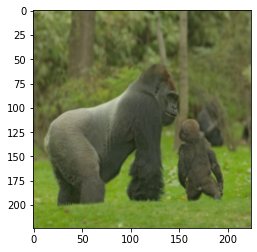

In [8]:
## adversarial image
output_adv_probs = F.softmax(output2, dim=1)
x_adv_pred_prob = np.round((torch.max(output_adv_probs.data, 1)[0][0]).cpu() * 100, 4)
x_adv_pred_prob = x_adv_pred_prob.item()

print(x_adv_pred)
print(x_adv_pred_prob)

x2 = image_tensor2.squeeze(0)
x2 = x2.mul((torch.FloatTensor(std)).to(device).view(3, 1, 1)).add(
    (torch.FloatTensor(mean)).to(device).view(3, 1, 1)).cpu().detach().numpy()  # reverse of normalization op- "unnormalize"
x2 = np.transpose(x2, (1, 2, 0))  # C X H X W  ==>   H X W X C
x2 = np.clip(x2, 0, 1)

plt.imsave(adv_filepath, x2)
plt.imshow(x2)
plt.show()

In [14]:
## Image quality assessment

dist = torch.as_tensor(x2).permute(2, 0, 1).unsqueeze(0)
ref = torch.as_tensor(x).permute(2, 0, 1).unsqueeze(0)

model1 = SSIM(channels=3) # 0~1 값, 1에 가까울수록 원본과 유사도 높음
score1 = model1(dist, ref, as_loss=False).item()

score2 = psnr(dist,ref).item()

print('SSIM of ResNet50: ', score1)
print('PSNR of ResNet50: ', score2)

SSIM of ResNet50:  0.883536159992218
PSNR of ResNet50:  26.486705780029297


In [13]:
## saving slm pattern
M = slm.cpu().detach().numpy()
df = pd.DataFrame(M)
df.to_excel('adv_filepath_slm/test_slm.xlsx', header=None, index=False)